# About Dataset

##Context

**Quora's** first public dataset is related to the problem of identifying duplicate questions. At Quora, an important product principle is that there should be a single question page for each logically distinct question. For example, the queries “What is the most populous state in the USA?” and “Which state in the United States has the most people?” should not exist separately on Quora because the intent behind both is identical. Having a canonical page for each logically distinct query makes knowledge-sharing more efficient in many ways: for example, knowledge seekers can access all the answers to a question in a single location, and writers can reach a larger readership than if that audience was divided amongst several pages.

The dataset is based on actual data from Quora and will give anyone the opportunity to train and test models of semantic equivalence.

## Content

There are over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.

## Downloading the data

In [68]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quora/question-pairs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2


In [69]:
import shutil
import os

source_path = "/root/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2"
destination_path = "/content"

try:
    shutil.move(source_path, destination_path)
    print(f"Successfully moved '{source_path}' to '{destination_path}'")
except FileNotFoundError:
    print(f"Error: Source path '{source_path}' not found.")
except Exception as e:
    print(f" N.P. : {e}")

if os.path.exists(os.path.join(destination_path, "2")):
    print(f"Dataset now exists in '{destination_path}'")

An error occurred: Destination path '/content/2' already exists
Dataset now exists in '/content'


In [70]:
!pip install fuzzywuzzy

## Necessary Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle



import warnings
warnings.filterwarnings('ignore')

In [72]:
csv = "/content/2/questions.csv"
df = pd.read_csv(csv)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [73]:
df.shape

(404351, 6)

In [74]:
print(df['question1'].isna().sum())
print(df['question2'].isna().sum())

1
2


In [75]:
df.dropna(inplace=True)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [77]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
345485,345485,677041,677042,What type of benefits do you have if you join ...,What type of benefits do you have if you join ...,0
212907,212907,419880,419881,I understand that the reason why black objects...,"When light gets absorbed into a material, wher...",0
198987,198987,392706,392707,What is the funniest joke you have ever read h...,What is the best joke you've ever hear?,1
222216,222216,438014,438015,Who can help me improve my English?,Who can help me in improving my English speaking?,1
202762,202762,400075,92802,Who are the best design?,Who are the top design bloggers?,0
209131,209131,412533,412534,How can I get a complete list of all my gmail ...,Where is my other gmail accounts?,1
314157,314157,616559,616560,Will computers ever be conscious?,Will computers ever have their own consciousness?,1
221680,221680,436973,436974,Why did Pahlaj Nihalani pass Befikre with a U/...,Who played mother of vani Kapoor in befikre?,0
242428,242428,477487,477488,What is the best online high school in the US?,What are good online high schools and how do t...,0
39542,39542,78769,78770,How can I upload copyrighted videos on YouTube?,Can I upload a non copyrighted video on youtube?,0


In [78]:
# Binary Classification

In [79]:
df.duplicated().sum()

0

In [80]:
df["is_duplicate"].value_counts()

,count
is_duplicate,
0,255042
1,149306


<Axes: xlabel='is_duplicate'>

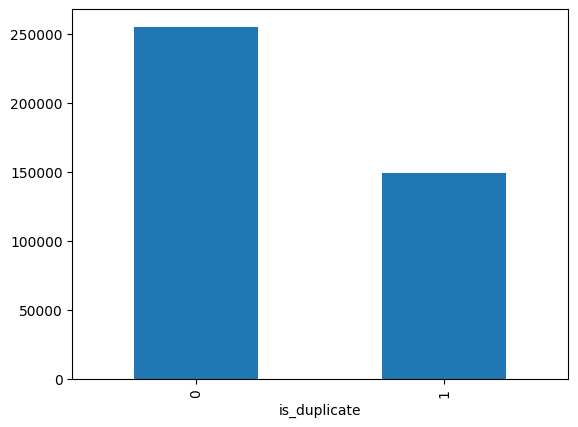

In [81]:
df["is_duplicate"].value_counts().plot(kind='bar')

**Our data is somewhat Imbalanced.**

## Downsampling

In [82]:
# Separate the dataset into majority and minority classes
df_majority = df[df['is_duplicate'] == 0]
df_minority = df[df['is_duplicate'] == 1]

# Downsample the majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution of the target class
print(df['is_duplicate'].value_counts())

is_duplicate
1    149306
0    149306
Name: count, dtype: int64


In [83]:
# Perfect

## Text Preprocessing :

### 1. Lowercasing
### 2. Stop-words Removal
### 3. Adding the new Features
### 4. Text Vecorization

In [84]:
# Lowercasing the question cols:

df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()

In [85]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,139827,276792,276793,what is the importance of smart objects in pho...,what is a smart object in photoshop?,1
1,161175,318664,318665,how do i check who blocked me on instagram?,is there a way to find out who blocked me on i...,1


In [86]:
# Stop-words Removal

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from the dataset
df['question1'] = df['question1'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df['question2'] = df['question2'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

## Adding useful features

In [88]:
nltk.download('punkt')
nltk.download('wordnet')

class Add_Features:
    def __init__(self, df):
        self.df = df
        self.stop_words = set(stopwords.words('english'))

    def jaccard_similarity(self, q1, q2):
        q1_set, q2_set = set(q1.split()), set(q2.split())
        return len(q1_set & q2_set) / len(q1_set | q2_set) if len(q1_set | q2_set) > 0 else 0

    def add_jaccard_similarity(self):
        tqdm.pandas(desc="Calculating Jaccard Similarity")
        self.df['jaccard_similarity'] = self.df.progress_apply(lambda x: self.jaccard_similarity(x['question1'], x['question2']), axis=1)

    def add_length_based_features(self):
        self.df['length_diff'] = abs(self.df['question1'].str.len() - self.df['question2'].str.len())
        self.df['word_count_diff'] = abs(self.df['question1'].str.split().apply(len) - self.df['question2'].str.split().apply(len))

    def add_word_overlap(self):
        def word_overlap(q1, q2):
            q1_words = set(q1.split()) - self.stop_words
            q2_words = set(q2.split()) - self.stop_words
            return len(q1_words & q2_words)

        tqdm.pandas(desc="Calculating Word Overlap")
        self.df['word_overlap'] = self.df.progress_apply(lambda x: word_overlap(x['question1'], x['question2']), axis=1)

    def add_fuzzy_features(self):
        tqdm.pandas(desc="Calculating Fuzzy Features")
        self.df['fuzz_ratio'] = self.df.progress_apply(lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
        self.df['fuzz_partial_ratio'] = self.df.progress_apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)

    def add_tfidf_similarity(self):
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(self.df['question1'].tolist() + self.df['question2'].tolist())
        q1_tfidf = tfidf_matrix[:len(self.df)]
        q2_tfidf = tfidf_matrix[len(self.df):]
        self.df['tfidf_similarity'] = [cosine_similarity(q1, q2)[0][0] for q1, q2 in zip(q1_tfidf, q2_tfidf)]

    def apply_all_features(self):
        self.add_jaccard_similarity()
        self.add_length_based_features()
        self.add_word_overlap()
        self.add_fuzzy_features()
        self.add_tfidf_similarity()
        return self.df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [89]:
feature_adder = Add_Features(df)
df_with_features = feature_adder.apply_all_features()

Calculating Fuzzy Features: 100%|██████████| 298612/298612 [04:14<00:00, 1171.18it/s]


In [90]:
df_with_features.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,jaccard_similarity,length_diff,word_count_diff,word_overlap,fuzz_ratio,fuzz_partial_ratio,tfidf_similarity
0,139827,276792,276793,importance smart objects photoshop?,smart object photoshop?,1,0.4,12,1,2,79,96,0.579916
1,161175,318664,318665,check blocked instagram?,way find blocked instagram?,1,0.4,3,1,2,75,79,0.640895


## Text Vectorisation

In [91]:
# Tokenize sentences
tqdm.pandas(desc="Tokenizing Sentences")
df_with_features['q1_tokens'] = df_with_features['question1'].progress_apply(lambda x: str(x).split())
df_with_features['q2_tokens'] = df_with_features['question2'].progress_apply(lambda x: str(x).split())

# Combine all sentences for Word2Vec training
sentences = df_with_features['q1_tokens'].tolist() + df_with_features['q2_tokens'].tolist()

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

Tokenizing Sentences: 100%|██████████| 298612/298612 [00:01<00:00, 157607.82it/s]


Training Word2Vec model...


In [92]:
# Function to compute sentence embeddings as the mean of word embeddings
def sentence_to_vec(tokens, model):
    words = [word for word in tokens if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

# Generate embeddings for each question
def add_embeddings(df, model):
    tqdm.pandas(desc="Generating Embeddings")
    df['q1_vec'] = df['q1_tokens'].progress_apply(lambda x: sentence_to_vec(x, model))
    df['q2_vec'] = df['q2_tokens'].progress_apply(lambda x: sentence_to_vec(x, model))
    return df

In [93]:
df_with_features = add_embeddings(df_with_features, w2v_model)

Generating Embeddings: 100%|██████████| 298612/298612 [00:13<00:00, 21732.09it/s]


In [94]:
# Combine embeddings into feature vectors
def combine_features(row):
    return np.concatenate((row['q1_vec'], row['q2_vec']))

df_with_features['features'] = df_with_features.apply(combine_features, axis=1)
X = np.vstack(df_with_features['features'].values)
y = df_with_features['is_duplicate']

## Model

In [95]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
def train_in_batches(model, X_train, y_train, batch_size):
    n_batches = int(np.ceil(len(X_train) / batch_size))
    for i in tqdm(range(n_batches), desc="Training in Batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_train))
        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]
        model.fit(X_batch, y_batch)
    return model

In [98]:
# Train RandomForest
print("Training RandomForest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True)
batch_size = 10000
rf_model = train_in_batches(rf_model, X_train, y_train, batch_size)

Training RandomForest...


Training in Batches: 100%|██████████| 24/24 [00:53<00:00,  2.24s/it]


In [99]:
rf_preds = rf_model.predict(X_test)

In [102]:
rf_acc = accuracy_score(y_test, rf_preds)
rf_acc

0.7174287962761415

In [103]:
rf_f1 = f1_score(y_test, rf_preds)
rf_f1

0.7157199649619298

In [104]:
print("Training XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_model = train_in_batches(xgb_model, X_train, y_train, batch_size)

Training XGBoost...


Training in Batches: 100%|██████████| 24/24 [11:44<00:00, 29.36s/it]


In [105]:
xgb_preds = xgb_model.predict(X_test)

In [106]:
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_acc

0.7261356596286188

In [107]:
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_f1

0.7223278554936846

## Prediction

In [108]:
def preprocess_questions(q1, q2):
    q1_tokens = str(q1).split()
    q2_tokens = str(q2).split()
    return q1_tokens, q2_tokens

def generate_embeddings(q1_tokens, q2_tokens, model):
    q1_vec = sentence_to_vec(q1_tokens, model)
    q2_vec = sentence_to_vec(q2_tokens, model)
    features = np.concatenate((q1_vec, q2_vec))
    return features

def predict_similarity(q1, q2, w2v_model, trained_model):
    q1_tokens, q2_tokens = preprocess_questions(q1, q2)

    features = generate_embeddings(q1_tokens, q2_tokens, w2v_model)

    # Predict using the trained model
    prediction = trained_model.predict([features])[0]
    probability = trained_model.predict_proba([features])[0]

    return prediction, probability

In [109]:
q1 = "What are the best ways to lose weight fast?"
q2 = "How can I lose weight quickly?"

In [110]:
chosen_model = xgb_model

In [111]:
pred, prob = predict_similarity(q1, q2, w2v_model, chosen_model)

In [112]:
print(f"Prediction: {'Duplicate' if pred == 1 else 'Not Duplicate'}")
print(f"Probability: {prob}")

Prediction: Not Duplicate
Probability: [0.6073694  0.39263055]


## Saving the model

In [114]:
import pickle

# Save models
with open('word2vec_model.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)